In [2]:
!sudo apt-get install libopencv-dev python-opencv
!git clone https://github.com/mpatacchiola/deepgaze.git
!cd deepgaze && git checkout 2.0 && sudo python setup.py install

!pip install pyyaml==5.1 gdown

import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# Some basic setup:
# Setup detectron2 logger
import torch
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
from google.colab import files

# import some common libraries
import numpy as np
import os, json, cv2, random
import networkx as nx
from collections import Counter, deque
from itertools import islice

from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

from deepgaze.saliency_map import FasaSaliencyMapping
import deepgaze
import deepgaze.saliency_map
from google.colab.patches import cv2_imshow



Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopencv-dev is already the newest version (3.2.0+dfsg-4ubuntu0.1).
The following NEW packages will be installed:
  python-opencv
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 535 kB of archives.
After this operation, 2,944 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [535 kB]
Fetched 535 kB in 1s (538 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Select

In [13]:
coloring = lambda x: x

def recolor_bfs(colors: dict, graph: nx.Graph) -> dict:
    """
    Use the information that 0 and 1 color will be close for us, to make image more distinguishable
    Parameters
    ----------
    colors: dict, old coloring
    graph: nx.Graph, graph of object connections

    Returns
    -------
    dict, new coloring, that uses that 0 and 1 is close colors
    """
    if not colors or not len(graph.nodes):
        return {}
    amount_of_colors = len(set(colors.values()))
    colors_range = deque(range(amount_of_colors))
    colors_freqs = Counter(colors.values())

    most_common_color = colors_freqs.most_common(1)[0][0]
    result = {most_common_color: colors_range.pop()}

    # find starting point - any node of most_common_color
    current_point = None
    for v in graph.nodes:
        if colors[v] == most_common_color:
            current_point = v
            break
    assert current_point is not None

    stack = deque()
    while len(result) < amount_of_colors:
        neighs = graph.neighbors(current_point)
        neighs = [v for v in neighs if colors[v] not in result]

        neighs_colors = {colors[v] for v in neighs}
        if neighs_colors:
            step = len(colors_range) // len(neighs_colors)
            colors_to_use = deque(islice(colors_range, None, None, step))
            assert len(colors_to_use) >= len(neighs_colors)  # maybe even ==
            for v in neighs:
                if colors[v] not in result:
                    result[colors[v]] = colors_to_use.pop()
                    colors_range.remove(result[colors[v]])

            colors_range.reverse()

        stack.extend(neighs)
        current_point = stack.popleft()

    return {k: result[v] for k, v in colors.items()}


def recolor_by_frequency(colors: dict) -> dict:
    """
    Use the information that 0 and 1 color will be close for us and info about the frequencies of similar objects
    to change the colors to new ones
    Args:
        colors: dict, old coloring

    Returns:
        dict, new coloring, that uses that 0 and 1 is close colors
    """
    replace_dict = {val: ind for ind, val in
                    enumerate(sorted(set(colors.values()), key=lambda x: list(colors.values()).count(colors[x])))}
    result_dict = {}
    for key in colors:
        result_dict[key] = replace_dict[colors[key]]
    return result_dict

coloring.recolor_bfs = recolor_bfs
coloring.recolor_by_frequency = coloring

In [14]:
mixing = lambda x: x

def combination(img1: np.ndarray, img2: np.ndarray, prc1: float, prc2: float) -> np.ndarray:
    """
    Combines the two images into one with given percentages
    Args:
        img1: np.ndarray, any int/float 2-3d image
        img2: np.ndarray, any int/float 2-3d image
        prc1: float, any fraction of first image in result
        prc2: float, any fraction of second image in result

    Returns:
        np.ndarray int, [0-255]
    """
    assert img1.shape == img2.shape
    img1 = (img1 - img1.min()) / (img1.max() - img1.min())
    img2 = (img2 - img2.min()) / (img2.max() - img2.min())
    res = img1 * prc1 + img2 * prc2
    res = (res - res.min()) / (res.max() - res.min()) * 255
    return res


mixing.combination = combination

In [15]:
class Highlighter:
    """
    The class prepared by Team Blue as part of CS291a Fall 2021, UCSB
    Use prepare_highlight_result() to get the result.
    Args:
        _shape: tuple of ints, the shape of picture to transform, example (640, 480, 3)
        _segmentation_thre5shold: float [0-1], threshold for detectron segmentation model,
        _tiny_object_size: int, size in pixels, less then which detected object is just deleted
        _intersection_fraction: float [0-1], for what fraction should object intersect to be "same" object
        _default_neighbour_diameter: int/None, size in pixels, located within less than this is "neighboring" for eye
         objects. Suggest to base on implant phosphene size. Use None for relative to object size detection
        _add_saliency_to_result: bool, to add or not to add saliency map to result
    """

    allowed_classes = {12: 'apple', 343: 'cube', 1035: 'stockings_(leg_wear)', 298: 'computer_keyboard',
                       23: 'trash_can', 40: 'ball', 56: 'baseball', 62: 'basketball', 125: 'book', 128: 'booklet',
                       132: 'bottle', 176: 'butter', 193: 'can', 326: 'crate', 346: 'cup', 348: 'cupcake',
                       471: 'football_(American)', 588: 'icecream', 648: 'lemon', 654: 'lightbulb', 735: 'notebook',
                       845: 'pop_(soda)', 867: 'pumpkin', 911: 'plastic_bag', 925: 'sandwich',
                       932: 'scale_(measuring_instrument)', 996: 'soccer_ball', 1001: 'softball',
                       1080: 'tape_(sticky_cloth_or_paper)', 1097: 'tennis_ball', 1118: 'tomato', 1168: 'volleyball',
                       793: 'pencil', 87: 'bell_pepper', 792: 'pen', 445: 'file_(tool)', 957: 'shaving_cream',
                       852: 'potato', 1066: 'syringe', 745: 'onion', 391: 'doughnut', 746: 'orange_(fruit)',
                       196: 'candle', 941: 'screwdriver', 667: 'lotion', 1226: 'yogurt', 681: 'marker', 421: 'egg',
                       462: 'flashlight', 1122: 'toothpaste', 1121: 'toothbrush', 995: 'soap', 594: 'igniter',
                       84: 'beer_can', 1183: 'water_bottle', 952: 'shampoo', 624: 'knife', 694: 'medicine', 656: 'lime',
                       788: 'pear', 311: 'edible_corn', 44: 'banana', 1229: 'zucchini', 622: 'kiwi_fruit',
                       811: 'pickle', 25: 'asparagus', 514: 'gourd', 285: 'coconut', 27: 'avocado', 786: 'peach',
                       677: 'mandarin_orange', 243: 'cherry', 818: 'pineapple', 304: 'cookie', 220: 'carrot',
                       516: 'grape'}

    def __init__(self, _shape: tuple, _segmentation_threshold: int = 0.015, _tiny_object_size: int = 200,
                 _intersection_fraction: int = 0.2, _default_neighbour_diameter: int = 30,
                 _add_saliency_to_result: int = False):
        self.shape = _shape
        self.tiny_object_size = _tiny_object_size
        self.intersection_fraction = _intersection_fraction
        self.default_neighbour_diameter = _default_neighbour_diameter
        self.add_saliency_to_result = _add_saliency_to_result
        self.saliency_map = deepgaze.saliency_map.FasaSaliencyMapping(self.shape[0], self.shape[1])
        self.segmentation_threshold = _segmentation_threshold
        self.segmentation_predictor = self.getPredictor()

    def getPredictor(self):
        """
        Prepares the detectron predictor (mask_rcnn) with pretrained on LVIS dataset.
        Returns:
            Predictor to get the saliency result from image
        """
        cfg = detectron2.config.get_cfg()
        cfg.merge_from_file(
            model_zoo.get_config_file('LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml'))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
            'LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml')
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.segmentation_threshold

        predictor = DefaultPredictor(cfg)
        return predictor

    def get_saliency(self, image: np.ndarray) -> np.ndarray:
        """
        Returns saliency map for given image.
        Args:
            image: np.ndarray, image to get the saliency map. Assume RGB image, no prove for other images.

        Returns:
            Saliency map in grayscale
        """
        assert image.shape == self.shape
        image = self.saliency_map.returnMask(image, tot_bins=8,
                                             format='BGR2LAB')  # get the mask from the original image
        image = cv2.GaussianBlur(image, (3, 3), 1)  # applying gaussin blur to make it pretty
        return image

    def get_segmentation_masks(self, image: np.ndarray, enable_allowlist: bool = True) -> np.ndarray:
        """
        Prepares layers of boolean masks for detected objects. One layer for one object.
        Args:
            image: np.ndarray float/int, RGB image for segmentation
            enable_allowlist: bool, for using or skipping predefined list of allowed classes (based on logic)

        Returns:
            np.ndarray of bool, (N, X, Y), where X, Y - image shape, N - number of detected objects
        """
        outputs = self.segmentation_predictor(image)
        layers = np.array(outputs['instances'].pred_masks.cpu())
        if enable_allowlist:
            to_delete = set()
            for ind, value in enumerate(outputs['instances'].pred_classes.cpu()):
                if value.item() not in self.allowed_classes:
                    to_delete.add(ind)
            layers = np.delete(layers, list(to_delete), 0)
        likeness = dict()
        for ind1 in range(len(layers)):
            for ind2 in range(ind1 + 1, len(layers)):
                likeness[ind1, ind2] = len(layers[ind1] == layers[ind2]) / layers.size

        to_delete = set()
        for i, j in likeness:
            if likeness[(i, j)] > self.intersection_fraction:
                if sum(layers[i]) > sum(layers[j]):
                    to_delete.add(j)
                else:
                    to_delete.add(j)
                if sum(layers[i]) < self.tiny_object_size:
                    to_delete.add(i)
                if sum(layers[j]) < self.tiny_object_size:
                    to_delete.add(j)
        layers = np.delete(layers, list(to_delete), 0)
        return layers

    def get_points_cloud(self, layer: np.ndarray, wind: int = 1) -> list:
        """
        Returns list of tuples point coordinates for given object layer for finding distances. Uses mask edge detection.
        Args:
            layer: np.ndarray True/False, mask layer of object
            wind: int, window size for edge detection

        Returns:
            list of tuples point coordinates for given object layer
        """
        return [(i, j) for i in range(layer.shape[0]) for j in range(layer.shape[1]) if
                layer[i, j] and not np.all(layer[i - wind:i + wind, j - wind:j + wind])]

    def get_shortest_distances(self, points_cloud_l1: list, points_cloud_l2: list) -> (float, tuple):
        """
        Finds the shortest euclidean distance between two objects, given by list of coordinates.
        Args:
            points_cloud_l1: list, list of coordinates
            points_cloud_l2: list, list of coordinates

        Returns:
            (float, tuple): the minimum distance and points which represents the shortest distance
        """
        min_dist = ((points_cloud_l1[0][0] - points_cloud_l2[0][0]) ** 2 + (
                points_cloud_l1[0][1] - points_cloud_l2[0][1]) ** 2) ** (1 / 2)
        min_points = ((points_cloud_l1[0][0], points_cloud_l1[0][1]), (points_cloud_l2[0][0], points_cloud_l2[0][1]))
        for x1, y1 in points_cloud_l1:
            for x2, y2 in points_cloud_l2:
                dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)
                if dist < min_dist:
                    min_dist = dist
                    min_points = ((x1, y1), (x2, y2))
        return min_dist, min_points

    def masks_to_graph(self, segmentation_masks: np.ndarray) -> nx.Graph:
        """
        Finds the graph of neighboring object on boolean masks of objects
        Args:
            segmentation_masks: np.ndarray bool (N, X, Y), N - number of objects, X, Y - image shape

        Returns:
            nx.Graph, with connections for those objects which is neighbours on picture. Objects identified by indexes.
        """
        diameter = self.default_neighbour_diameter  # how many "pixels" phospehene are?
        graph = nx.Graph()
        for ind1 in range(len(segmentation_masks)):
            graph.add_node(ind1)
            for ind2 in range(ind1 + 1, len(segmentation_masks)):
                points1 = self.get_points_cloud(segmentation_masks[ind1])
                points2 = self.get_points_cloud(segmentation_masks[ind2])
                if not self.default_neighbour_diameter:
                    diameter = max(max(max(points1, key=lambda x, y: x) - min(points1, key=lambda x, y: x),
                                       max(points1, key=lambda x, y: y) - min(points1, key=lambda x, y: y)),
                                   max(max(points1, key=lambda x, y: x) - min(points1, key=lambda x, y: x),
                                       max(points1, key=lambda x, y: y) - min(points1, key=lambda x, y: y))) * 0.1
                distance, points = self.get_shortest_distances(points1, points2)
                if distance < diameter:
                    graph.add_edge(ind1, ind2, distance=distance)
        return graph

    def color_me(self, graph: nx.Graph) -> dict:
        """
        Function of greedy/some other algorithm for graph coloring
        Args:
            graph: nx.Graph to color

        Returns:
            dict, of object and int colors for all graph objects
        """
        colors = nx.coloring.greedy_color(graph, strategy='random_sequential')
        return colors

    def paint_me(self, segmentation_layers: np.ndarray, colors: dict) -> np.ndarray:
        """
        Creates X,Y image with integer value for each object if it is "on" the picture
        Args:
            segmentation_layers: np.ndarray bool, of masks for each object
            colors: dict {index: color}, color for each object

        Returns:
            np.ndarray, (X, Y) picture int values
        """
        result = np.zeros(self.shape[:2])
        for ind, layer in enumerate(segmentation_layers):
            color = colors[ind] + 1
            result[layer] = color
        return result

    def prepare_highlight_result(self, image: np.ndarray) -> np.ndarray:
        """
        Function that uses class settings and functions for creating the highlighted image
        Args:
            image: np.ndarray, initial RGB image

        Returns:
            np.ndarray, highlighted grayscale image
        """
        grayscale_result = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        saliency_result = self.get_saliency(image)
        segmentation_layers = self.get_segmentation_masks(image, True)

        graph = self.masks_to_graph(segmentation_layers)
        colors = self.color_me(graph)
        colors = coloring.recolor_bfs(colors, graph)
        segmentation_result = self.paint_me(segmentation_layers, colors)

        result = mixing.combination(grayscale_result, segmentation_result, 0.3, 0.7)
        if self.add_saliency_to_result:
            result = mixing.combination(saliency_result, result, self.add_saliency_to_result,
                                      1 - self.add_saliency_to_result)

        return result


In [16]:
# get test dataset
!gdown https://drive.google.com/uc?id=1RJLrikeIfhBIERgh0jAhnRbV5VplO_9k
!unzip -q rgb.zip

Downloading...
From: https://drive.google.com/uc?id=1RJLrikeIfhBIERgh0jAhnRbV5VplO_9k
To: /content/rgb.zip
100% 1.16G/1.16G [00:06<00:00, 167MB/s]
replace rgb/rgb0000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


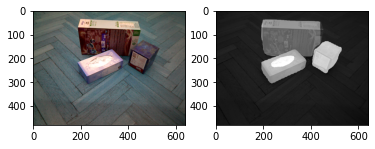

In [17]:
image_name = "rgb0002.png"
image = cv2.imread(f"rgb/{image_name}")
blue = Highlighter(image.shape)

higlighted_image = blue.prepare_highlight_result(image)

fix, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(higlighted_image, cmap="gray")
plt.show()

